In [1]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import joblib
import torch
import torch.nn as nn
from torchvision.transforms import Resize, ToTensor, Compose, Normalize, transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from os import listdir
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from torchvision.models import mobilenet_v3_large
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet_v3_large_model = mobilenet_v3_large(pretrained=True)
mobilenet_v3_large_model = nn.Sequential(*list(mobilenet_v3_large_model.children())[:-1])
mobilenet_v3_large_model = mobilenet_v3_large_model.to(device)
mobilenet_v3_large_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 109MB/s] 


Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [3]:
ensemble_model_svm_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/ensemble_model_svm.pkl')
pca_model_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/pca_model.pkl')
scaler_model_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/scaler.pkl')
model1_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/model1.pkl')
model2_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/model2.pkl')
model3_mobilenet_pca = joblib.load('/kaggle/input/full-model/mobilenet V3/model3.pkl')

pca_model_mobilenet = joblib.load('/kaggle/input/full-model/mobilenet V3 no pca/pca_model.pkl')
svm_model_mobilenet = joblib.load('/kaggle/input/full-model/mobilenet V3 no pca/svm.pkl')
scaler_model_mobilenet = joblib.load('/kaggle/input/full-model/mobilenet V3 no pca/scaler.pkl')

In [4]:
data = pd.read_csv("/kaggle/input/brain-tumor-csv/Brain Tumor.csv")
data.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [5]:
images = data.Image
classes = data.Class
image_label_dict = data.set_index('Image')['Class'].to_dict()

In [6]:
def preprocess_image(image_path):
  image = Image.open(image_path).convert('RGB')
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = transform(image)
  image = image.unsqueeze(0)
  return image.to(device)
def extract_features(image, model):
  with torch.no_grad():
    feature = model(image).squeeze().cpu().numpy()
  return feature
def extract_features_from_image(image_path, model):
  image = preprocess_image(image_path)
  features = extract_features(image, model)
  return features
def preprocess_image_pca(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.numpy().flatten()
    return image

In [7]:
dir_list = '/kaggle/input/reloaded-crop/Crop/'
X_resnet = []
X_pca_orig = []
Y = []
filename_list = []

for filename in tqdm(listdir(dir_list)):
  if filename.endswith('.jpg'):
    #print(filename)
    filename_list.append(filename)
    path = dir_list + filename
    label = image_label_dict.get(filename.split('.')[0], None)
    if filename == 'Image3460.jpg':
        print(label)
    if label is not None:
      features = extract_features_from_image(path, mobilenet_v3_large_model)
      X_resnet.append(features)
      feature_pca = preprocess_image_pca(path)
      X_pca_orig.append(feature_pca)
      Y.append(label)
X_resnet = np.array(X_resnet)
X_pca_orig = np.array(X_pca_orig)
Y = np.array(Y)

 85%|████████▌ | 3205/3762 [02:16<00:22, 24.67it/s]

0


100%|██████████| 3762/3762 [02:40<00:00, 23.46it/s]


In [8]:
print(X_resnet[0].shape)
print(X_pca_orig[0].shape)

(960,)
(150528,)


In [9]:
pca_model = pca_model_mobilenet_pca
X_pca = pca_model.transform(X_pca_orig)
print(X_pca[0].shape)
X_pca = np.hstack((X_resnet, X_pca))

(378,)


In [10]:
indices = np.arange(len(filename_list))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_resnet, Y, indices, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(X_train, y_train, train_indices, test_size=0.1765, random_state=42)

test_image_names = [filename_list[i] for i in test_indices]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

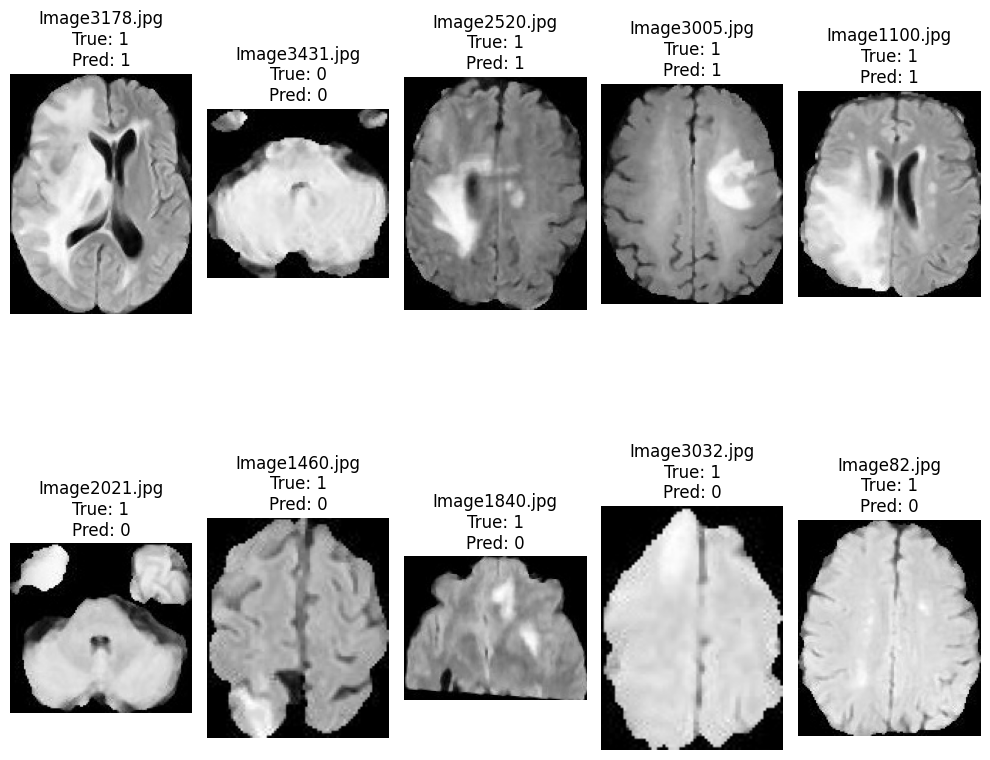

In [11]:
image_dir = "/kaggle/input/reloaded-crop/Crop/"

y_test_pred = svm_model_mobilenet.predict(X_test)

correctly_classified_indices = [i for i in range(len(y_test)) if y_test_pred[i] == y_test[i]]
misclassified_indices = [i for i in range(len(y_test)) if y_test_pred[i] != y_test[i]]

#correctly_classified_names = [test_image_names[i] for i in correctly_classified_indices[:5]]  
#correctly_classified_true_labels = [y_test[i] for i in correctly_classified_indices[:5]]
#correctly_classified_pred_labels = [y_test_pred[i] for i in correctly_classified_indices[:5]]

correctly_classified_names = [test_image_names[correctly_classified_indices[i]] for i in [0, 1, 2, 3, 4]]
correctly_classified_true_labels = [y_test[correctly_classified_indices[i]] for i in [0, 1, 2, 3, 4]]
correctly_classified_pred_labels = [y_test_pred[correctly_classified_indices[i]] for i in [0, 1, 2, 3, 4]]

#misclassified_names = [test_image_names[i] for i in misclassified_indices[:5]] 
#misclassified_true_labels = [y_test[i] for i in misclassified_indices[:5]]
#misclassified_pred_labels = [y_test_pred[i] for i in misclassified_indices[:5]]
misclassified_names = [test_image_names[misclassified_indices[i]] for i in [0, 1, 2, 3, 6]] 
misclassified_true_labels = [y_test[misclassified_indices[i]] for i in [0, 1, 2, 3, 6]]
misclassified_pred_labels = [y_test_pred[misclassified_indices[i]] for i in [0, 1, 2, 3, 6]]

plt.figure(figsize=(10, 10))

for i, img_name in enumerate(correctly_classified_names):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(image_dir, img_name)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"{img_name}\nTrue: {correctly_classified_true_labels[i]}\nPred: {correctly_classified_pred_labels[i]}")
    plt.axis('off')

for i, img_name in enumerate(misclassified_names):
    plt.subplot(2, 5, i+6)
    img_path = os.path.join(image_dir, img_name)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"{img_name}\nTrue: {misclassified_true_labels[i]}\nPred: {misclassified_pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
indices = np.arange(len(filename_list))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_pca, Y, indices, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(X_train, y_train, train_indices, test_size=0.1765, random_state=42)

test_image_names = [filename_list[i] for i in test_indices]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


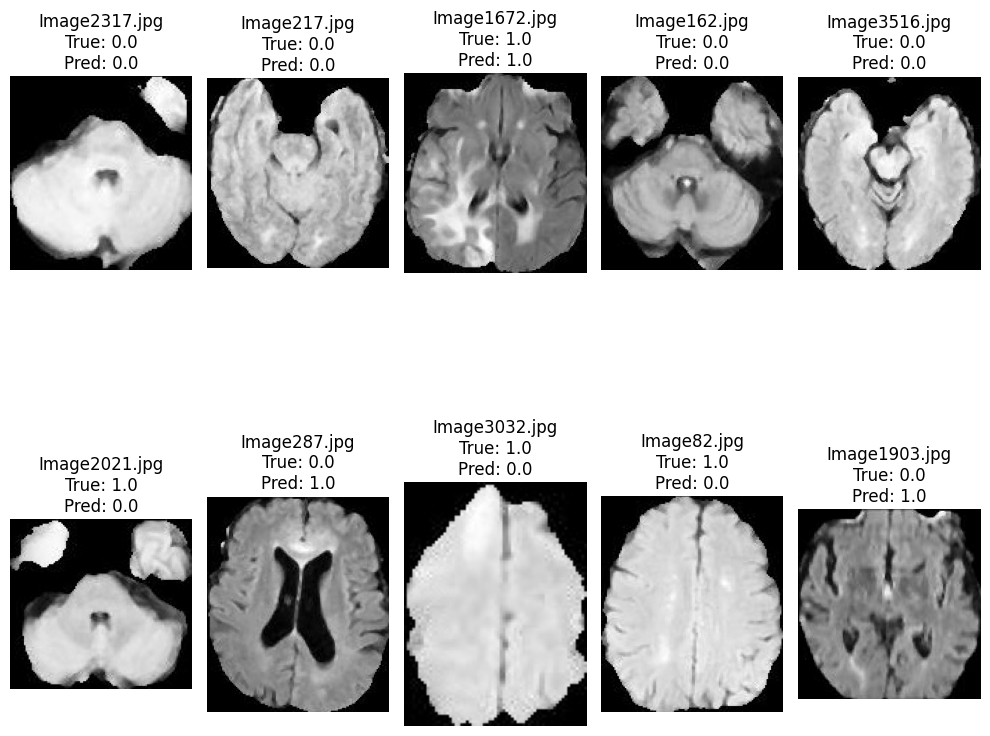

In [17]:
y_pred1_prob = model1_mobilenet_pca.predict(X_test).flatten()
y_pred2_prob = model2_mobilenet_pca.predict(X_test).flatten()
y_pred3_prob = model3_mobilenet_pca.predict(X_test).flatten()
y_pred_probs = np.column_stack((y_pred1_prob, y_pred2_prob, y_pred3_prob))
y_test_pred = ensemble_model_svm_mobilenet_pca.predict(y_pred_probs)

correctly_classified_indices = [i for i in range(len(y_test)) if y_test_pred[i] == y_test[i]]
misclassified_indices = [i for i in range(len(y_test)) if y_test_pred[i] != y_test[i]]

#correctly_classified_names = [test_image_names[i] for i in correctly_classified_indices[:5]]  
#correctly_classified_true_labels = [y_test[i] for i in correctly_classified_indices[:5]]
#correctly_classified_pred_labels = [y_test_pred[i] for i in correctly_classified_indices[:5]]
correctly_classified_names = [test_image_names[correctly_classified_indices[i]] for i in [5, 6, 7, 8, 9]]
correctly_classified_true_labels = [y_test[correctly_classified_indices[i]] for i in [5, 6, 7, 8, 9]]
correctly_classified_pred_labels = [y_test_pred[correctly_classified_indices[i]] for i in [5, 6, 7, 8, 9]]

#misclassified_names = [test_image_names[i] for i in misclassified_indices[:5]] 
#misclassified_true_labels = [y_test[i] for i in misclassified_indices[:5]]
#misclassified_pred_labels = [y_test_pred[i] for i in misclassified_indices[:5]]
misclassified_names = [test_image_names[misclassified_indices[i]] for i in [0, 1, 6, 9, 13]] 
misclassified_true_labels = [y_test[misclassified_indices[i]] for i in [0, 1, 6, 9, 13]]
misclassified_pred_labels = [y_test_pred[misclassified_indices[i]] for i in [0, 1, 6, 9, 13]]

plt.figure(figsize=(10, 10))

for i, img_name in enumerate(correctly_classified_names):
    plt.subplot(2, 5, i+1)
    img_path = os.path.join(image_dir, img_name)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"{img_name}\nTrue: {correctly_classified_true_labels[i]}\nPred: {correctly_classified_pred_labels[i]}")
    plt.axis('off')

for i, img_name in enumerate(misclassified_names):
    plt.subplot(2, 5, i+6)
    img_path = os.path.join(image_dir, img_name)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"{img_name}\nTrue: {misclassified_true_labels[i]}\nPred: {misclassified_pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()